In this Python notebook, we show a first effort at using Logistic Generalised Additive Models in order to see which principal indexes differentiate well between schools in the Center-North and schools in the South, which tend to struggle more in the Invalsi tests. 

While we have used PyGam for easeness of interface, the pvalues are not relevant and mgcv pvalues were also inspected to assess the relevance of the covariates. 

These results were showed in the first presentation. They are not included in the report, as we have then progressed further in the analysis.

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('../Data/gppp.csv')

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline
pd.set_option('display.max_columns', None)

In [3]:
from pygam import PoissonGAM, s, te, LinearGAM, f, l, LogisticGAM

X = df.loc[:,['opinione_invalsi', 'utilizzo_invalsi',
       'coinvolgimento_genitori_prop', 'coinvolgimento_genitori_eff','strumenti']]

y = df['Sud']

gam = LogisticGAM(s(0)+s(1)+s(2)+s(3)+s(4),n_splines = 20).fit(X, y)
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     41.3835
Link Function:                        LogitLink Log Likelihood:                                  -352.7709
Number of Samples:                          658 AIC:                                              788.3088
                                                AICc:                                             794.2922
                                                UBRE:                                               3.2484
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1807
Feature Function                  Lam

<ipython-input-3-674db4efa36d>:9: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


<Figure size 1500x500 with 0 Axes>

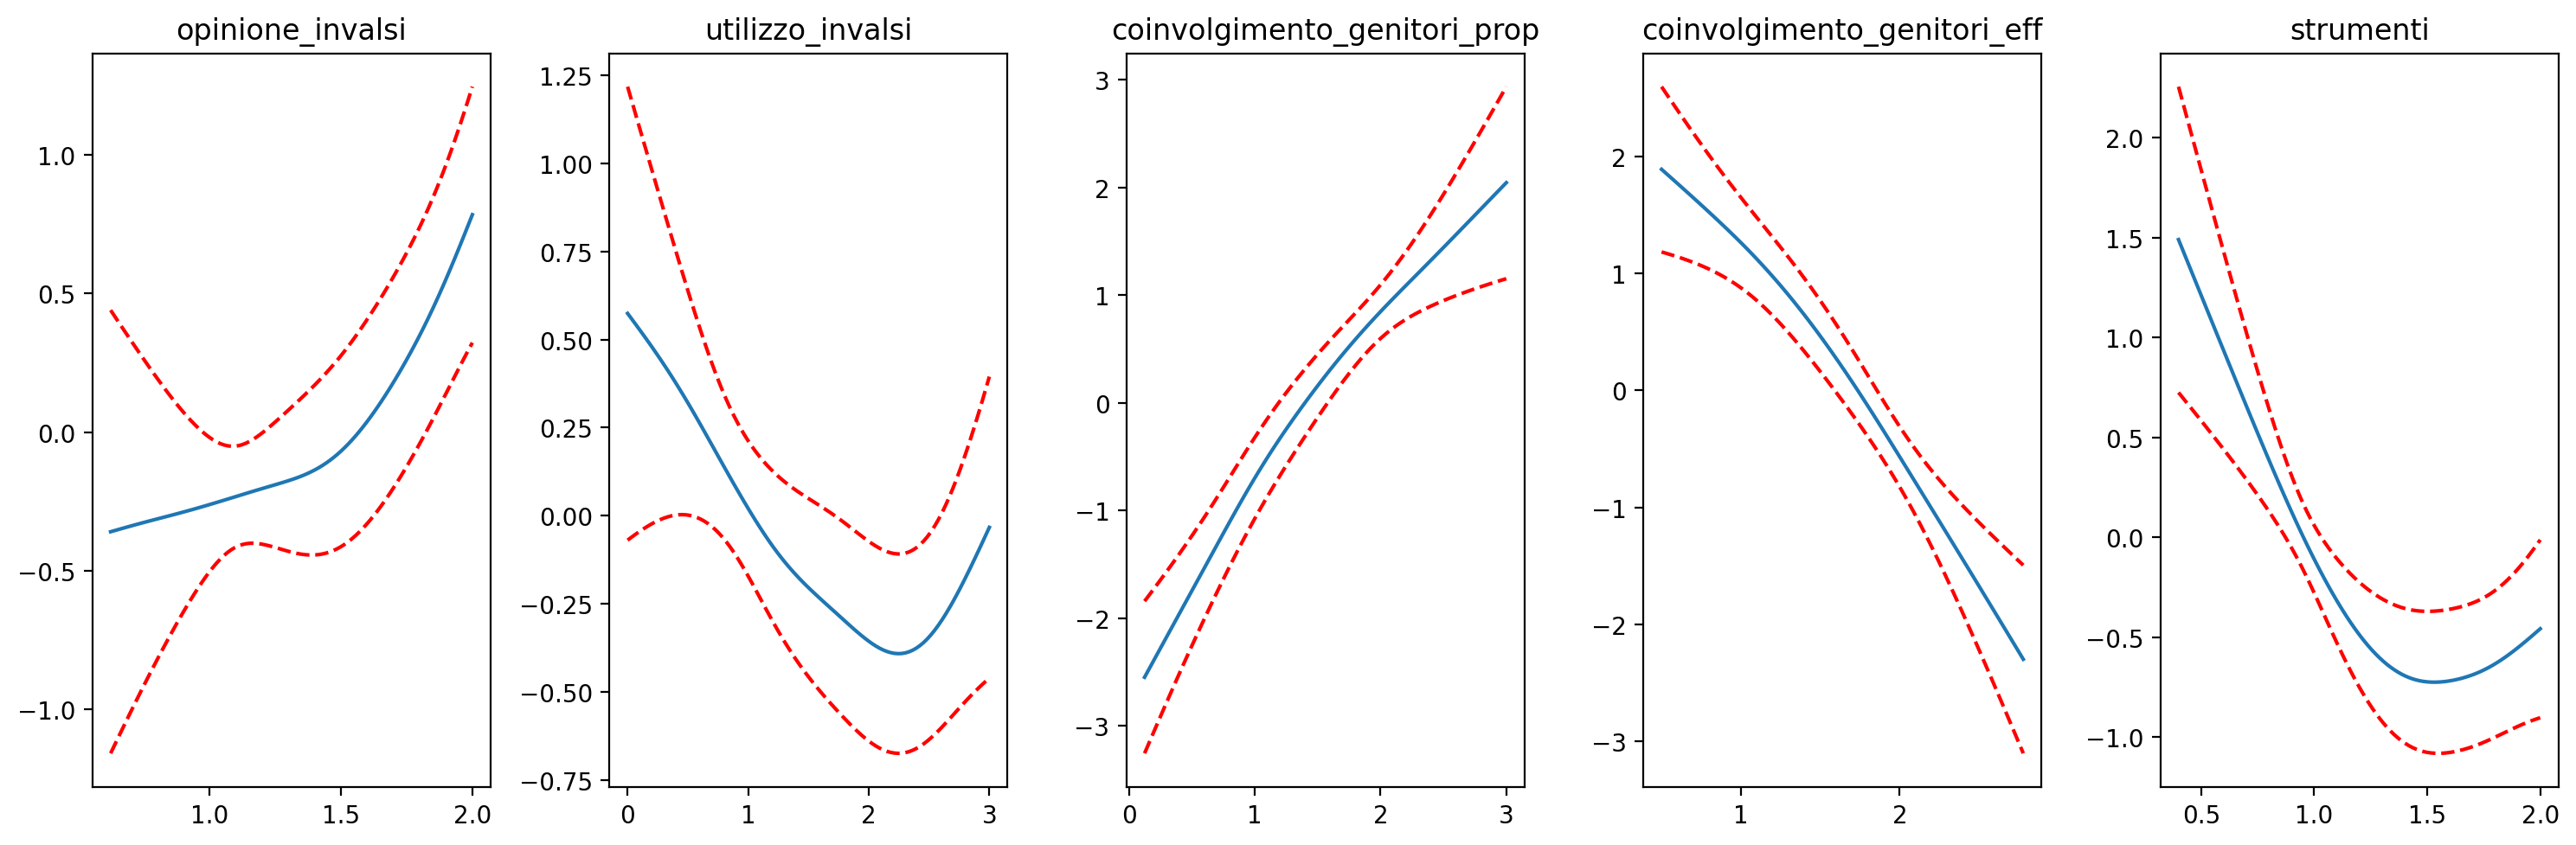

In [5]:

gam.gridsearch(X, y)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = 15, 5
plt.figure();
fig, axs = plt.subplots(1,5);

titles = X.columns

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    #ax.scatter(X.iloc[:,i], y, facecolor='gray', edgecolors='none')
    ax.set_title(titles[i]);
    
plt.tight_layout()

In [36]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import cross_validate


import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold, KFold

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from tqdm import tqdm

from sklearn.preprocessing import StandardScaler

import numpy as np

In [2]:
def splines_degree_selector(i1,i2,i3,i4,i5):

    i1 = int(i1)
    i2 = int(i2)
    i3 = int(i3)
    i4 = int(i4)
    i5 = int(i5)

    X = df.loc[:,['opinione_invalsi', 'utilizzo_invalsi',
           'coinvolgimento_genitori_prop', 'coinvolgimento_genitori_eff','strumenti']]

    n_samples, n_features = X.shape
    n_splits = 5
    cv = StratifiedKFold(n_splits=n_splits, shuffle = True, random_state = 0)
    y = df['Sud']

    classifier = LogisticGAM(s(0,n_splines=i1)+s(1,n_splines=i2)+s(2,n_splines=i3)+s(3,n_splines=i4)+s(4,n_splines=5), fit_intercept = False, verbose = False)

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)

    colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
    lw = 2

    i = 0
    for (train, test), color in zip(cv.split(X, y), colors):
        try:
            cl = classifier.fit(X.iloc[train], y.iloc[train])
            probas_ = cl.predict_proba(X.iloc[test])
            fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_)
            mean_tpr += np.interp(mean_fpr, fpr, tpr)
            mean_tpr[0] = 0.0
            roc_auc = auc(fpr, tpr)
        except:
            return 0
    
    mean_tpr /= cv.get_n_splits(X, y)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    
    return(roc_auc)

In [ ]:
from bayes_opt import BayesianOptimization
import scipy.sparse as sps

pbounds = {'i1':(6,20),'i2':(5,20),'i3':(5,20),'i4':(4,20),'i5':(6,20)}

optimizer = BayesianOptimization(
    f=splines_degree_selector,
    pbounds=pbounds,
    verbose=1  # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
)

optimizer.maximize(
        init_points=50,  # random steps
        n_iter= 50
    )

print(optimizer.max)

In [115]:
optimizer.max

{'target': 0.7174019607843137,
 'params': {'i1': 6.0,
  'i2': 6.649356682405709,
  'i3': 5.0,
  'i4': 5.650628159760415,
  'i5': 7.509819869797727}}

In [120]:
from pygam import PoissonGAM, s, te, LinearGAM, f, l, LogisticGAM


#X = spezzi.iloc[:,-9:]

X = df.loc[:,['opinione_invalsi', 'utilizzo_invalsi',
       'coinvolgimento_genitori_prop', 'coinvolgimento_genitori_eff','strumenti']]

y = df['Sud']

gam = LogisticGAM(s(0,n_splines=6)+s(1,n_splines=7)+s(2,n_splines=5)+s(3,n_splines=5)+s(4,n_splines=8)).fit(X, y)
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     11.9651
Link Function:                        LogitLink Log Likelihood:                                  -382.8765
Number of Samples:                          668 AIC:                                              789.6833
                                                AICc:                                              790.237
                                                UBRE:                                               3.1965
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1246
Feature Function                  Lam

<ipython-input-120-adb31384e330>:12: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [163]:
gam.statistics_

{'n_samples': 668,
 'm_features': 5,
 'edof_per_coef': array([2.07983555e-01, 5.08649935e-01, 5.25711938e-01, 6.65079076e-01,
        5.85120206e-01, 2.76826777e-02, 3.58121132e-01, 3.86257967e-01,
        4.74435860e-01, 4.96482654e-01, 2.97501467e-01, 1.79183525e-02,
        7.01196288e-03, 6.12598354e-01, 3.94518127e-01, 9.06487203e-02,
        1.19795588e-02, 4.36347853e-03, 4.16262559e-01, 5.51356805e-01,
        1.10083276e-01, 1.76998324e-03, 6.93689563e-03, 7.83735686e-02,
        2.92589338e-01, 4.85969201e-01, 4.36164580e-01, 4.98270667e-01,
        3.00265697e-01, 1.10319831e-02, 3.33165397e-23, 5.22118321e-23]),
 'edof': 8.861139576401927,
 'scale': 1.0,
 'cov': array([[ 0.27466511,  0.134637  , -0.0019048 , ...,  0.0183095 ,
          0.02386473,  0.04959107],
        [ 0.134637  ,  0.07143668,  0.00920178, ...,  0.00887598,
          0.01318445,  0.02500648],
        [-0.0019048 ,  0.00920178,  0.01914046, ..., -0.00040932,
          0.00266456,  0.00101536],
        ...,

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


<Figure size 1500x500 with 0 Axes>

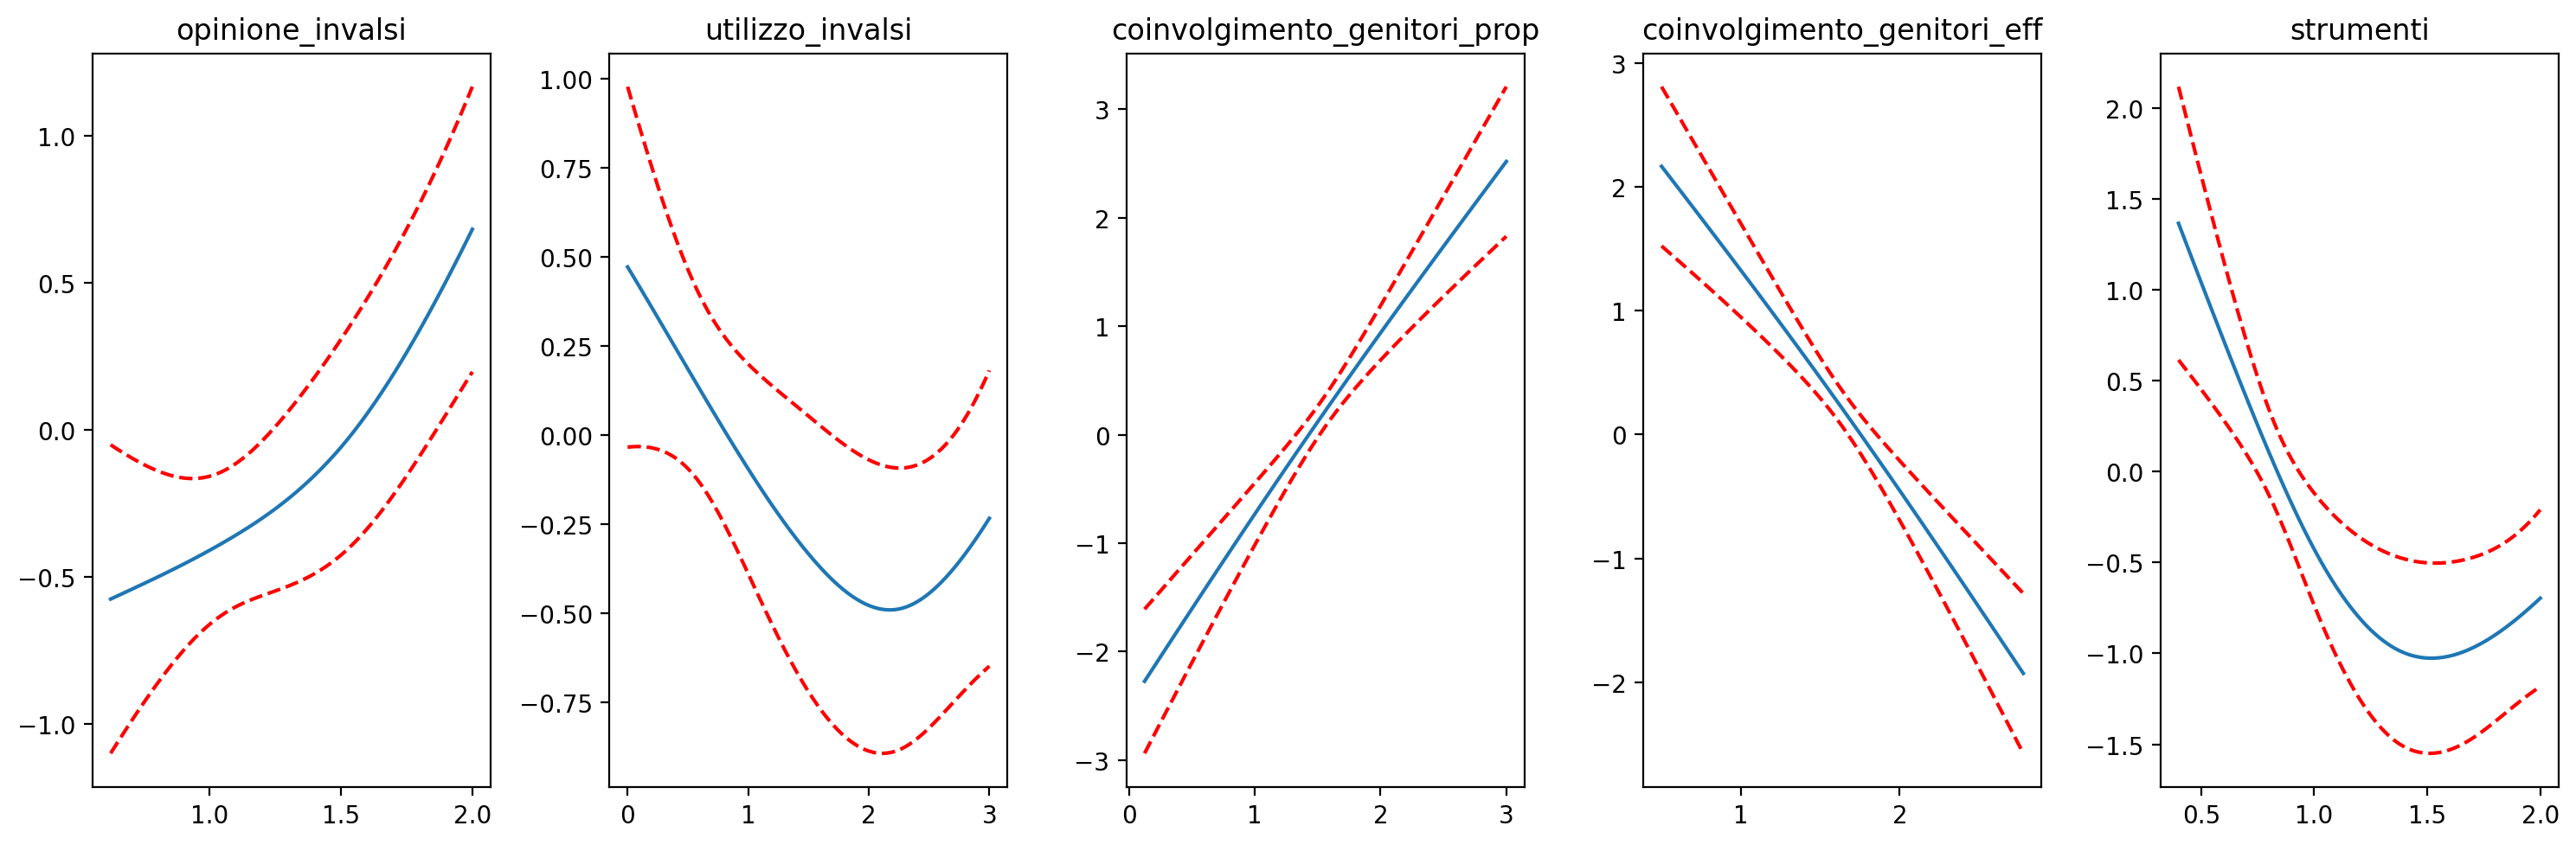

In [145]:
gam.gridsearch(X, y)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = 15, 5
plt.figure();
fig, axs = plt.subplots(1,5);

titles = X.columns

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    #ax.scatter(X.iloc[:,i], y, facecolor='gray', edgecolors='none')
    ax.set_title(titles[i]);
    
plt.savefig('sud_presidi'+str(i)+'.png', transparent = 'true')
    
plt.tight_layout()


In [123]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = 8,6

In [148]:
from sklearn.metrics import accuracy_score

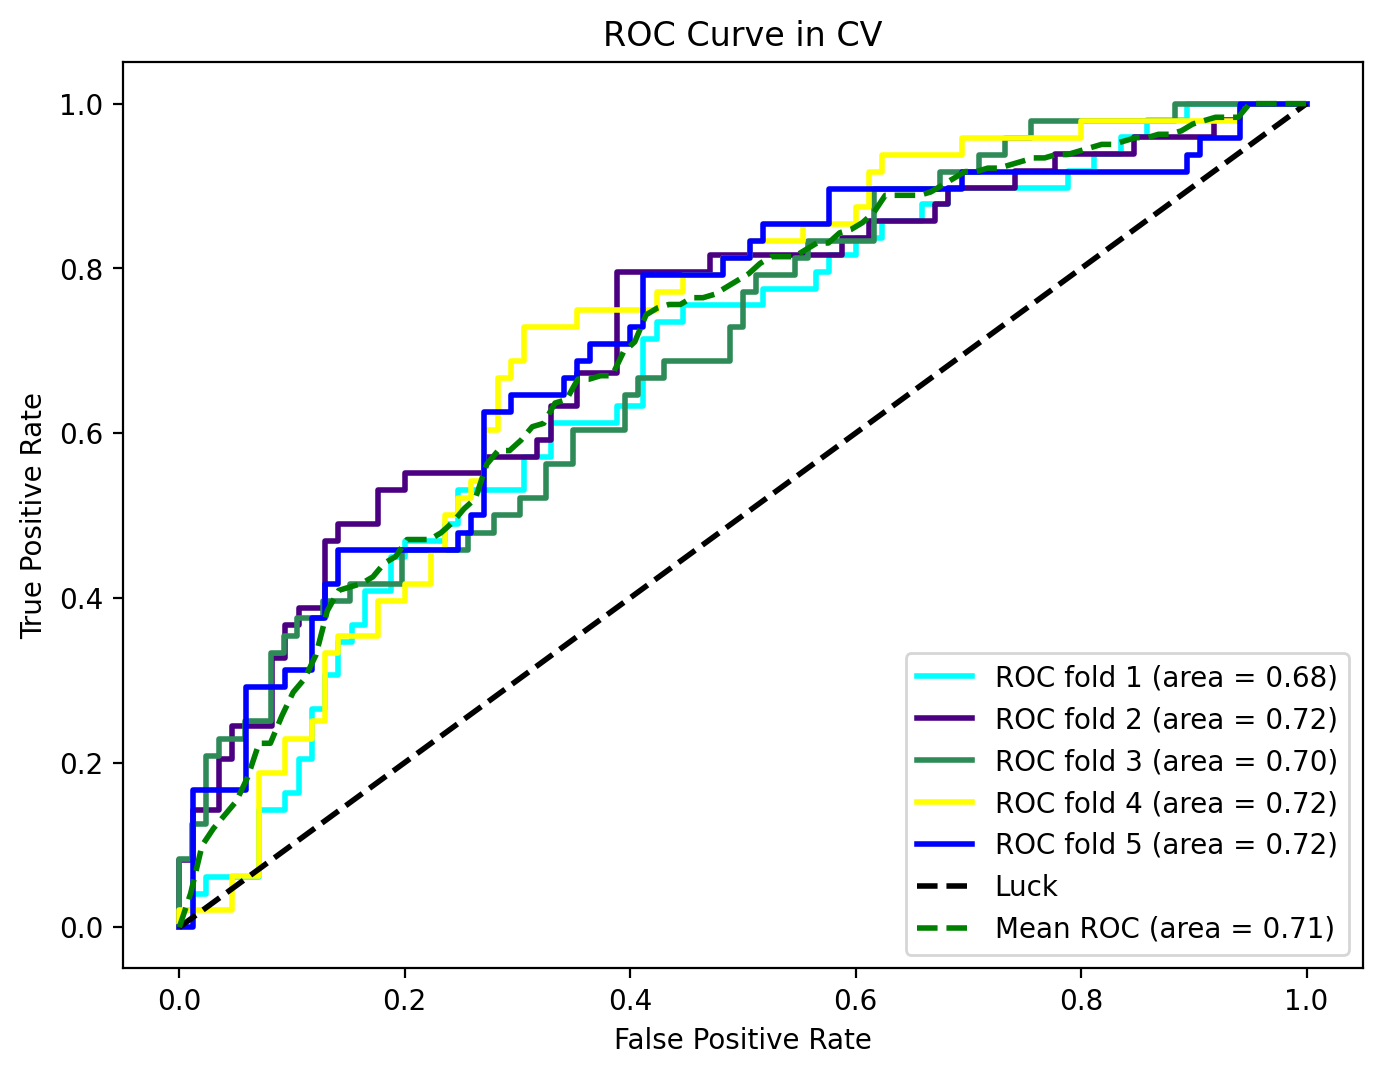

0.6586915048816071


In [157]:
X = df.loc[:,['opinione_invalsi', 'utilizzo_invalsi',
       'coinvolgimento_genitori_prop', 'coinvolgimento_genitori_eff','strumenti']]

n_samples, n_features = X.shape
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle = True, random_state = 0)
plt.figure()

y = df['Sud']

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = 8,6
classifier = LogisticGAM(s(0,n_splines=6)+s(1,n_splines=7)+s(2,n_splines=5)+s(3,n_splines=5)+s(4,n_splines=8)).fit(X, y)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2

i = 1
acc = []
for (train, test), color in zip(cv.split(X, y), colors):
    cl = classifier.fit(X.iloc[train], y.iloc[train])
    probas_ = cl.predict_proba(X.iloc[test])
    fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_)
    mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    acc.append(accuracy_score(y.iloc[test],(cl.predict_proba(X.iloc[test])>=0.4).astype(bool)))
    i += 1
    


    
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= cv.get_n_splits(X, y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve in CV')
plt.legend(loc="lower right")
plt.savefig('ROC.png', transparent = True)
plt.show()
print("Mean accuracy:", np.mean(acc))